In [1]:
# Import relevant packages
import pymaid
import seaborn as sns
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import sys
sys.path.insert(0,'Users/brandon/Documents/Bootcamp2019')
import CATMAID_CRED



In [2]:
# Initialize CATMAID and load data
myInstance = CATMAID_CRED.CATMAID_CRED()
with open('demo_data.json', 'r') as f:
    json_neurons = json.load(f)

str_neurons = json.dumps(json_neurons)
nl = pymaid.json2neuron(str_neurons)

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


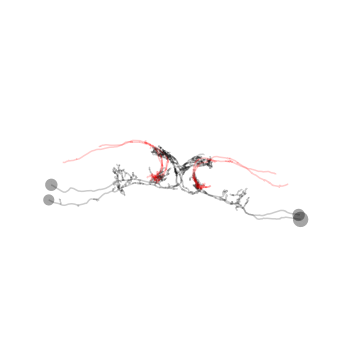

In [3]:
# 1a. Plot all of the dbd neurons in red and a08a neurons in black.
# first, we need to get the index of the sensory neurons and the interneurons.  One way to do this is to index by if there is a soma present. 
sensory_index = [i for i,x in enumerate(nl.soma) if not x]
interneuron_index = [i for i,x in enumerate(nl.soma) if x]
sensory_neurons = nl[sensory_index]
interneurons = nl[interneuron_index]

fig,ax = pymaid.plot2d([sensory_neurons], connectors=False,linewidth=1.5, method='3d',color = 'r',alpha = .2)
fig,ax = pymaid.plot2d([interneurons], ax = ax, connectors=False,linewidth=1.5, method='3d',color = 'k',alpha = .2)

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


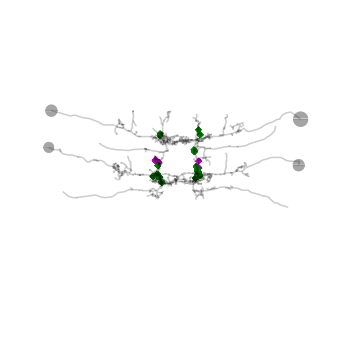

In [4]:
# 1b. Plot a08as and dbds in black, and plot the synapses from dbds to to a08as in the same segment in green, and intersegmental connections in magenta.  Plot from a dorsal view.
# Get the connectors between all a08a and dbd synapses.

cn_table_a1a1 = pymaid.get_connectors_between(sensory_neurons[0,3],interneurons[1,3],directional=True)
cn_table_a1a2 = pymaid.get_connectors_between(sensory_neurons[0,3],interneurons[0,2],directional=True)
cn_table_a2a2 = pymaid.get_connectors_between(sensory_neurons[1,2],interneurons[0,2],directional=True)
cn_table_a2a1 = pymaid.get_connectors_between(sensory_neurons[1,2],interneurons[1,3],directional=True)

# First plot dbd and a08a neurons.
fig,ax = pymaid.plot2d([sensory_neurons], connectors=False,linewidth=1.5, method='3d',color = 'k',alpha = .2)
fig,ax = pymaid.plot2d([interneurons], ax = ax, connectors=False,linewidth=1.5, method='3d',color = 'k',alpha = .2)

# Next plot the common synapses on top. Hint: you need to figure out how to convert a dataframe column from a list to an array.  
conloc_a1a1 = cn_table_a1a1.connector_loc.values
conloc_a1a1  = [val for sublist in conloc_a1a1 for val in conloc_a1a1]
conloc_a2a2 = cn_table_a2a2.connector_loc.values
conloc_a2a2 = [val for sublist in conloc_a2a2 for val in conloc_a2a2]
conloc_same = np.concatenate([np.array(conloc_a1a1),np.array(conloc_a2a2)])

conloc_a1a2 = cn_table_a1a2.connector_loc.values
conloc_a1a2  = [val for sublist in conloc_a1a2 for val in conloc_a1a2]
conloc_a2a1 = cn_table_a2a1.connector_loc.values
conloc_a2a1 = [val for sublist in conloc_a2a1 for val in conloc_a2a1]
conloc_inter = np.concatenate([np.array(conloc_a2a1),np.array(conloc_a2a1)])

fig,ax = pymaid.plot2d(np.array(conloc_same), method='3d', ax=ax,
                       scatter_kws={'s': 20,
                                    'color': 'g',
                                    'marker': 'D'})

fig,ax = pymaid.plot2d(np.array(conloc_inter), method='3d', ax=ax,
                       scatter_kws={'s': 20,
                                    'color': 'm',
                                    'marker': 'D'})
                       
ax.elev = 90



INFO  : Retrieving and filtering connectivity... (pymaid)
INFO  : Finished! (pymaid)


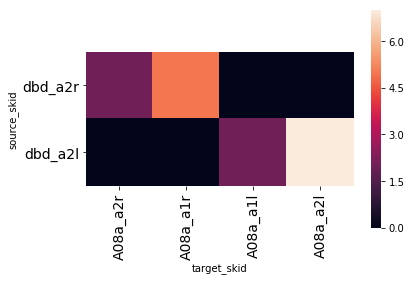

In [5]:
#1c.  It looks like the dbd in the a2 segment has synapses onto both the A1 and A2 A08a neurons.  Get the connectivity between dbd_a2 and a08a a1/2.
dbd = nl[2,3]
a08a = nl[6,7,4,1]

neuron_adj = pymaid.adjacency_matrix(dbd,a08a)
g = sns.heatmap(neuron_adj, square=True)
g.set_yticklabels(dbd.neuron_name, rotation=0, fontsize=14)
g.set_xticklabels(a08a.neuron_name, rotation=90, fontsize=14)
plt.show()

In [6]:
# 2.  In Sales, 2018, our lab used the a08a/dbd pair to examine the role of axon guidance in the establishment of proper partner choice and subcellular localization of targeting.  
# To do this, Emily misexpressed a repulsive axon guidance cue expressed at the midline of the VNC in order to move the dbd axon more laterally.  A08a has two principle dendritic arbors.  
a08a

,neuron_name,skeleton_id,n_nodes,n_connectors,n_branch_nodes,n_end_nodes,open_ends,cable_length,review_status,soma
0,A08a_a2r,18435548,1936,176,144,154,2,268.651602,NA,True
1,A08a_a1r,19806174,2604,262,215,234,0,351.814254,NA,True
2,A08a_a1l,12820537,1993,171,152,166,1,285.821738,NA,True
3,A08a_a2l,19810511,1824,153,127,140,1,240.598635,NA,True


In [7]:
# 2. Cut out just the lateral and medial dendrites of a08a_a1r. Hint: The sensory neuron vbd makes synapses onto the lateral arbor.  You want to cut at branch points.  Use the functions pymaid.classify_nodes to find branch points and pymaid.dist_between
# to measure distances between treenodes.
neuron = a08a[1]
table = pymaid.get_partners(neuron,threshold=3)

cn_table_dbd = pymaid.get_connectors_between(table.skeleton_id[0],neuron)
cn_table_vbd = pymaid.get_connectors_between(table.skeleton_id[7],neuron)

neuron = pymaid.classify_nodes(neuron, inplace=False)

nodetype = list(neuron.nodes.type)
branches = [i for i,x in enumerate(nodetype) if x == 'branch']



INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 23 pre-, 16 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


In [45]:
dist_vbd = []
dist_dbd = []
for i in range(len(branches)):
    
    dist_vbd.append(pymaid.dist_between(neuron,cn_table_vbd.treenode2_id[0],neuron.nodes.treenode_id[branches[i]]))
    dist_dbd.append(pymaid.dist_between(neuron,cn_table_dbd.treenode2_id[0],neuron.nodes.treenode_id[branches[i]]))
    
dist_vbd = np.array(dist_vbd)
dist_dbd = np.array(dist_dbd)

lateral_index = np.where(dist_vbd == min(dist_vbd))
medial_index = np.where(dist_dbd == min(dist_dbd))
lateral_branch = neuron.nodes.treenode_id[branches[np.asscalar(lateral_index[0])]]
medial_branch = neuron.nodes.treenode_id[branches[np.asscalar(medial_index[0])]]
lateral_dendrite = pymaid.cut_neuron(neuron,lateral_branch,ret='distal')
medial_dendrite = pymaid.cut_neuron(neuron,medial_branch,ret='distal')

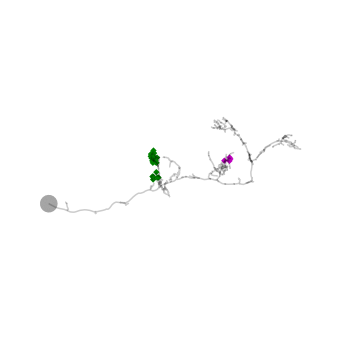

In [46]:
fig,ax = pymaid.plot2d([neuron], connectors=False,linewidth=1.5, method='3d',color = 'k',alpha = .2)

fig,ax = pymaid.plot2d(lateral_dendrite.connectors[['x','y','z']].values, method='3d', ax=ax,
                       scatter_kws={'s': 20,
                                    'color': 'g',
                                    'marker': 'D'})

fig,ax = pymaid.plot2d(medial_dendrite.connectors[['x','y','z']].values, method='3d', ax=ax,
                       scatter_kws={'s': 20,
                                    'color': 'm',
                                    'marker': 'D'})
                       


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2ff19978>)

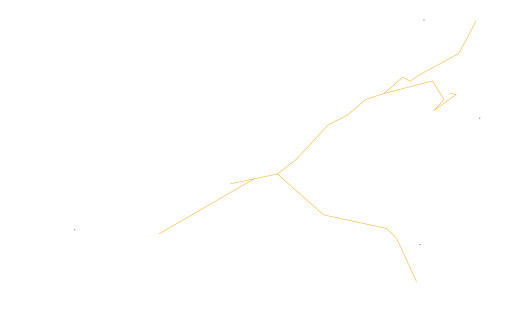